In [1]:

# so to push through the DOT processing
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pyproj
import scipy.io as io
import numpy as np
import pandas as pd
import os
import glob
from scipy import stats
import datetime as dt
from dateutil.relativedelta import relativedelta
from numba import jit
import copy
import itertools
import scipy.io
import sys
import imp
import gc
from scipy.interpolate import griddata
import shapefile
from invoke import run
import DOT
import data_year as dy
import grid_set as gs

Welcome to the DOT processing scripts #1

This will take the raw .elev files, a geoid netCDF file, and interpolate the DOT and SLA on a grid. 

The scripts in this note book call lots of custom functions/classes/methods included in the DOT/grid_set/data_year.py modules.

First we define the user set options - mainly the grid and where to find the data. Check the annotations

In [3]:
#### DATA PATHS

# where the paths live
CS2_path = '/Volumes/BU_extra/CryoSat/'
# where the interpolated geoids will live
geoid_dir = 'temp_geoids/'
# where to save our data
offset_save_path = 'Our_new_data/Gridded_raw_DOT/harry_example/'


In [ ]:
#### this gets the porjection that we'll use to move the tracks to a grid
# Also is the frame work the grid is based upon
#### INTIALISE PROJECTION
m = Basemap(projection='stere', lon_0=0.0, lat_0=90, lat_ts=70, 
                height = 3335000*2, width = 3335000*2)


In [5]:
#### SET UP THE DATES
# this is the date we start collecting data on
this_month = dt.datetime(2014,1,1) #start date
# this initialises the class that will hold the data 
# and do the leg work. The important bit here is the 'relativedelta'
# sets the time period to consider for collecting tracks. 
# In general a month is most sensible for good data.
# Shorter will however be processed quicker for invesigation. But there will be gaps.
data_month = DOT.CS_tracks(relativedelta( days = 1),this_month,m) # track collection period


In [6]:
#### GEOID OPTIONS
# in general set them all to true.
# if you're trouble shooting, make the geoids once, then don't trash them, then don't make them again
make_geoids = True
trash_geoids = False 
load_geoid = True
# this is the original geoid that we'll use to interpolate
geoid_master = 'Geoids/GEOID_GOCO03s_raw.nc'


In [7]:
#### NEW GRID
# creates a grid/mask/extra grid info (shape etc)
# relies on the grid_set module
# once the grids have been made, they can be saved, the reloaded to save time.
data_month.set_grid_dxy(50e3,50e3)
# data_month.get_grid_info()
# data_month.save_grid("grids/Polar_stereo_50km.npz")
data_month.load_grid("grids/Polar_stereo_50km.npz")

# Also for masks
#### IMPORTANT: INFLATE THE MASK BY 200KM for offset calculation
# doesn't stop the binning, but is needed later
### note masks don't currently work for the antartic because basemap
# data_month.get_grid_mask(inflate = 200e3)
# data_month.save_mask("grids/Polar_stereo_50km_mask_inf_200km.npz")
data_month.load_mask("grids/Polar_stereo_50km_mask_inf_200km.npz")

data_month.check_grid()

Got a grid res =  134  x  134
Note that all grid info is in ny x nx grids, whilst data is in nx x ny
Grid distances calculated:  49489.4578067645  x  49489.4578067645
Grid saved in grids/Polar_stereo_50km.npz
Mask saved in grids/Polar_stereo_50km_mask_inf_200km.npz


Now for the good stuff - processing - it's all under the hood

In [8]:
# finds all the data available
data_month.find_tracks(CS2_path)

In [14]:
# look at the files! there are 3 subclaaes now for the 3 modes
data_month.LRM.files[1]

'/Volumes/BU_extra/CryoSat/201401_LRM/elev/CS_LTA__SIR_LRM_2__20140101T010238_20140101T012011_C001.elev'

In [16]:

### makes geoids
### note this relies on external functions
# these are in DOT.py
# cmd = "awk '{print $7, $6}' "+filename+" > "+geoid_dir+"SARlong_lat.xy"
# cmd = "gmt grdtrack "+geoid_dir+"SARlong_lat.xy -G"+geoid_file+" -N  -n"+mode+" > "+file_write 
### SO YOU NEED awk
### SO YOU NEED gmt grdtrack 
### I got 'gmt grdtrack' through macports, you can too, or by some other method???
if make_geoids:
    data_month.make_geoids(geoid_master,geoid_dir)

made the geoid files
made the geoid files
made the geoid files


In [17]:
# the files are now read in, saved in their class all tidy like
# the SAR class is now split into SAR_o and SAR_l classes
### load files
data_month.load_tracks(load_geoid,geoid_dir)

Loading LRM
Loading SAR
Loading SARIN


We'll now a little time out to plot what we've got  so far

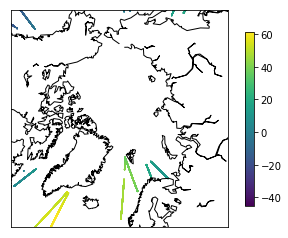

In [26]:
# lets see the LRM elevation scatter on a map
# this is in a pandas array ID:s
        # col ID [st,val,lat,lon,elev_abs,elev_mean]
        # col ID usecols=[0,1,5,6,7,8]
m.scatter(data_month.LRM.xpts,data_month.LRM.ypts,
          c=data_month.LRM.pd_cs[8],
          s = 0.1)
m.drawcoastlines()
plt.colorbar(shrink = 0.8)
plt.show()


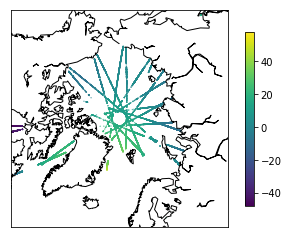

In [27]:
# lets see the SAR_lead equivalent geoid interpolated
# this is in a pandas array ID:s
        # col ID [lon,lat,geoid]
m.scatter(data_month.SAR_l.xpts,data_month.SAR_l.ypts,
          c=data_month.SAR_l.pd_gd[2],
          s = 0.1)
m.drawcoastlines()
plt.colorbar(shrink = 0.8)
plt.show()

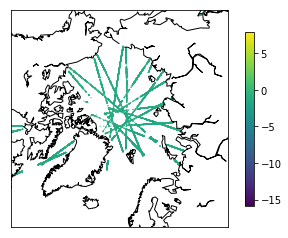

In [28]:
# lets see the SAR_lead DOT
# this is in a pandas array ID:s
        # col ID [lon,lat,geoid]
m.scatter(data_month.SAR_l.xpts,data_month.SAR_l.ypts,
          c=data_month.SAR_l.DOT,
          s = 0.1)
m.drawcoastlines()
plt.colorbar(shrink = 0.8)
plt.show()

In [29]:
# now on with the processing 
# lets bin the tracks onto the grid
### bin tracks
data_month.bin_tracks(load_geoid)
    
# and compare the modes
### calc offsets
data_month.calc_offsets(data_month.mask)
    

Binning LRM
Binning SAR_o
Binning SAR_l
Binning SARIN


Let's plot again!

here are the gridded versions of what me made above

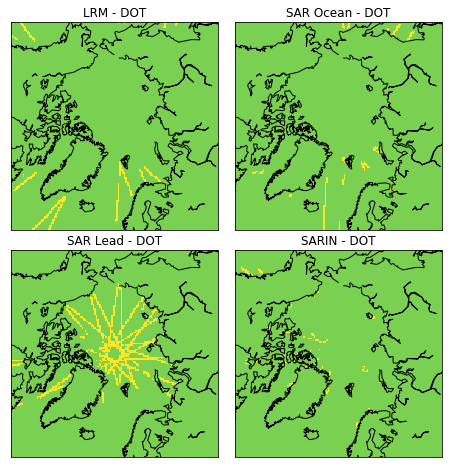

In [34]:
# Here is the DOT for the different modes

f = plt.figure(figsize=[8,8])

plt.subplot(2,2,1)
m.pcolormesh(data_month.xpts,data_month.ypts,
          np.transpose(np.isfinite(data_month.LRM.DOT_bin)),
             vmin = -2.0,vmax = 0.5)
m.drawcoastlines()
plt.title("LRM - DOT")
plt.subplot(2,2,2)
m.pcolormesh(data_month.xpts,data_month.ypts,
          np.transpose(np.isfinite(data_month.SAR_o.DOT_bin)),
             vmin = -2.0,vmax = 0.5)
m.drawcoastlines()
plt.title("SAR Ocean - DOT")
plt.subplot(2,2,3)
m.pcolormesh(data_month.xpts,data_month.ypts,
          np.transpose(np.isfinite(data_month.SAR_l.DOT_bin)),
             vmin = -2.0,vmax = 0.5)
m.drawcoastlines()
plt.title("SAR Lead - DOT")
plt.subplot(2,2,4)
m.pcolormesh(data_month.xpts,data_month.ypts,
          np.transpose(np.isfinite(data_month.SARIN.DOT_bin)),
             vmin = -2.0,vmax = 0.5)
m.drawcoastlines()
plt.title("SARIN - DOT")
plt.subplots_adjust(hspace = 0.1,wspace=0.01)
plt.show()

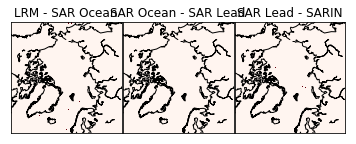

In [31]:
# these are the differences between the SLA for the various modes
# this is the 'mode offset' used later


plt.subplot(1,3,1)
m.pcolormesh(data_month.xpts,data_month.ypts,
          np.transpose(np.isfinite(data_month.SAR_o.offset)),cmap = 'Reds',vmin = 0.0,vmax = 1.0)
m.drawcoastlines()
plt.title("LRM - SAR Ocean")
plt.subplot(1,3,2)
m.pcolormesh(data_month.xpts,data_month.ypts,
          np.transpose(np.isfinite(data_month.SAR_l.offset)),cmap = 'Reds')
m.drawcoastlines()
plt.title("SAR Ocean - SAR Lead")
plt.subplot(1,3,3)
m.pcolormesh(data_month.xpts,data_month.ypts,
          np.transpose(np.isfinite(data_month.SARIN.offset)),cmap = 'Reds')
m.drawcoastlines()
plt.title("SAR Lead - SARIN")
plt.subplots_adjust(hspace = 0.01,wspace=0.01)
plt.show()

In [ ]:
# finally lets save what we've created!
file_save = offset_save_path+"offset_save_"+data_month.time.strftime('%Y%m%d')+".npz"
data_month.save_offsets_npz(file_save)
    

In [ ]:
# these final scripts come from when you want to process lots of data
# it cleans away all the extra data dont want.
# deletes the extra geoid tracks
# then moves all the limits to the next time period
### clean the geoids
if trash_geoids:
    data_month.LRM.trash_geoids(geoid_dir)
    data_month.SAR_o.trash_geoids(geoid_dir)
    data_month.SAR_l.trash_geoids(geoid_dir)
    data_month.SARIN.trash_geoids(geoid_dir)
### next time slot
### clean the tracks and data
data_month.next_time()
nt += 1
gc.collect()